In this notebook we choose the specific compound to analyze

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import datetime
tqdm.pandas()

## Load the data and drop series with out a unique dose level

The database contains information on the evolution of the concentration of chemical substances in the blood plasma of living subjects. Many different molecules are described only by their names, which provide no information about their structure. The values come from different studies with subjects of various species, ages, and sexes, using different biochemical analysis methods and conducted by different scientific teams. The administration of the chemicals was also carried out through different routes and with varying loading times (time needed to reach peak concentration in the blood plasma). Therefore, it is challenging to compare the data and extract meaningful information.

In [2]:
df = pd.read_csv("Dataset/cleaned.csv", index_col=0)
df.time_hr = pd.to_timedelta(df.time_hr, unit = "hours")
print("Before filtering", len(df))


def single_dose_level(group):
    
    unique_vals = group.dose_level_normalized.unique()
    
    if len(unique_vals) != 1:
        return9
    
    return not pd.isna(unique_vals[0])

df = df[df.dose_duration != "continuous"]

df = df.groupby("fk_series_id").filter(single_dose_level)
print("after filtering", len(df))

df.species = df.species.str.lower()
df.head()

Before filtering 10352
after filtering 7396


,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,...,sex,age,age_category,notes,subtype,height,weight,weight_kg,weight_estimated,series_length
0,1,0.069826,2.618893,NaN,NaN,NaN,NaN,0 days 00:04:11.351999999,0.00261,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2,0.0,16
1,1,0.239928,122.156713,NaN,NaN,NaN,NaN,0 days 00:14:23.712000,0.12215,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2,0.0,16
2,1,0.407653,340.571116,47.781570,NaN,NaN,NaN,0 days 00:24:27.540000,0.34057,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2,0.0,16
3,1,0.766816,990.431853,76.792296,NaN,NaN,NaN,0 days 00:46:00.516000,0.99043,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2,0.0,16
4,1,1.066636,510.409394,54.607509,NaN,NaN,NaN,0 days 01:03:59.867999999,0.51040,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2,0.0,16


In [4]:
df.columns

Index(['fk_series_id', 'time_original', 'conc_original', 'conc_sd_original',
       'conc_lower_bound_original', 'conc_upper_bound_original',
       'no_conc_val_type', 'time_hr', 'conc', 'conc_sd', 'conc_lower_bound',
       'conc_upper_bound', 'analyte_name_original', 'fk_analyzed_chemical_id',
       'author_comment', 'conc_units_normalized', 'analytical_method_detail',
       'n_subjects_in_series', 'fk_subject_id', 'conc_medium_normalized',
       'curator_comment', 'fk_study_id', 'radiolabeled', 'analyte_dtxsid',
       'analyte_casrn', 'test_substance_dtxsid', 'test_substance_casrn',
       'fk_test_chemical_id', 'fk_dosed_chemical_id', 'dose_level_normalized',
       'administration_route_normalized', 'dose_duration', 'parameter_name',
       'parameter_value', 'species', 'sex', 'age', 'age_category', 'notes',
       'subtype', 'height', 'weight', 'weight_kg', 'weight_estimated',
       'series_length'],
      dtype='object')

## Inspecting which Concentrate to predict

The article about rifampicin focused on one substance, so we will reproduce this example by choosing one.   
The paper did not try to predict the timeseries autoregressivly, rather they choose to predict certain time stamps all once. 
Because of this we try to find substances where the measurements are done in the same time interval.


Because of the task "and another to predict the 
time series from two observations" we try to atleasst find series with a length of 3. Sadly there was not much data with regular timepoints. We even checked the most freqeuent subsets of the times with length 3, but were not really succesfull. We even tried to round according to the time scale.

In [15]:
def get_unique_days(x):
    """Return unique days from a series, adaptively rounded."""
    return tuple(x.unique())


def most_common_subset(sets, subset_len = 3):
    """This functions finds the most common subset in a list of subsets of a given lenth
    
    We use subset 3 here such that we have 2 datapoints as input and atleast one as output
    """
    subset_counter = defaultdict(lambda:0)

    sets = [frozenset(s) for s in sets]
    
    max_len = max(len(s) for s in sets)
    
    
        
    for s in sets:
            
        if subset_len > len(s):
                continue
            
        for subset in combinations(s, subset_len):
            subset_counter[frozenset(subset)] += 1

    
    
    if len(subset_counter):
        max_val = max(subset_counter.values())
        best_sets = sorted([a for a,i in subset_counter.items() if i == max_val], key=len, reverse=True)
        
    
        return best_sets[0], max_val

    else:
        return None, 0

def freq_most_common_subset(group):
    
    
    # round based on max times
    time_in_minutes = group['time_hr'].astype('timedelta64[s]') / 3600
    
    max_time = time_in_minutes.max() / datetime.timedelta(hours = 1)
    
    
    if max_time < 1: 
        # less than a day -> dont  round
        group["time_rounded"] = time_in_minutes
    elif max_time < 86400 * 7:  
        # Less than a week -> round to minutes

        group["time_rounded"] = np.round(time_in_minutes, decimals = 0) 
    elif max_time < 86400 * 30:  
        # Less than a month -> round to hours
        
        
        group["time_rounded"] = np.round(time_in_minutes / 60, decimals = 0)
    else:  
        # Month or greater -> round to day
        group["time_rounded"] = np.round(time_in_minutes / 60 / 24, decimals = 0)
        
    
    time_hr_per_series = group.groupby("fk_series_id", ).time_rounded.apply(get_unique_days)
    
    common_set, count = most_common_subset(time_hr_per_series.values)
    
    return count


def n_unique(x):
    return len(x.unique())


def max_time_freq(df):
    def get_unique_days(x):
        return tuple(x['time_hr'].unique()) 

    unique_time_patterns = df.groupby("fk_series_id", ).apply(get_unique_days)
    return unique_time_patterns.value_counts().max()

In [16]:

freq_most_common = df.groupby("analyte_name_original").progress_apply(freq_most_common_subset)


common = df.groupby("analyte_name_original").agg({"series_length": ["min", "max","mean","count"], "fk_series_id" : [n_unique],"dose_level_normalized": [n_unique], "fk_study_id" : [n_unique], "species" : [np.unique], "time_hr": [n_unique],"dose_duration": [n_unique], "analytical_method_detail" : n_unique, "analytical_method_detail" : n_unique})
common["freq_most_common_3_set"] = freq_most_common.loc[common.index]

common = common.sort_values("freq_most_common_3_set", ascending=False)
common.head(10)


100%|███████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 171.01it/s]


series_length                       \
                                         min max       mean count   
analyte_name_original                                               
[14]C                                      3  15   9.927835   485   
2,4-Dichlorophenoxyacetic acid             3  13   9.139394   330   
benzene                                    4  19  13.447674   344   
L-Ephedrine                                7   9   8.502959   169   
benzo[a]pyrene                             4  15  13.104839   248   
phenacetin                                 3  12   8.103448   145   
Propyzamide                                5   9   7.767677    99   
3-hydroxy benzo[a]pyrene                   4   4   4.000000    48   
Naphthalene                                4  10   8.266187   139   
Benzo[a]pyrene 7,8-dihydrodiol             4   4   4.000000    48   

                               fk_series_id dose_level_normalized fk_study_id  \
                                   n_unique              n_unique    n_unique   
analyte_name_original                                                           
[14]C                                    78                     9          13   
2,4-Dichlorophenoxyacetic acid           40                     8          11   
benzene                                  30                     6           6   
L-Ephedrine                              20                     4           5   
benzo[a]pyrene                           21                     5           7   
phenacetin                               19                     6           8   
Propyzamide                              13                     4           4   
3-hydroxy benzo[a]pyrene                 12                     3           3   
Naphthalene                              18                     3           3   
Benzo[a]pyrene 7,8-dihydrodiol           12                     3           3   

                                              species  time_hr dose_duration  \
                                               unique n_unique      n_unique   
analyte_name_original                                                          
[14]C                                    [mouse, rat]       21             2   
2,4-Dichlorophenoxyacetic acid  [hamster, mouse, rat]       19             1   
benzene                                  [human, rat]      279             3   
L-Ephedrine                                     [rat]        9             1   
benzo[a]pyrene                           [mouse, rat]       49             2   
phenacetin                          [dog, human, rat]       50             2   
Propyzamide                                     [rat]       14             1   
3-hydroxy benzo[a]pyrene                        [rat]        5             1   
Naphthalene                                     [rat]       11             1   
Benzo[a]pyrene 7,8-dihydrodiol                  [rat]        5             1   

                               analytical_method_detail freq_most_common_3_set  
                                               n_unique                         
analyte_name_original                                                           
[14]C                                                 1                     40  
2,4-Dichlorophenoxyacetic acid                        1                     33  
benzene                                               4                     23  
L-Ephedrine                                           1                     20  
benzo[a]pyrene                                        1                     18  
phenacetin                                            2                     16  
Propyzamide                                           1                     13  
3-hydroxy benzo[a]pyrene                              1                     12  
Naphthalene                                           1                     12  
Benzo[a]pyrene 7,8-dihydrodiol                        1           

We choose [14]C because of the highest freq_most_common_3_set val. Carbon-14 is used as a marker for only one other molecule: Amberonne. Therefore, there is no risk of training the model on multiple tested molecules. Additionally, the subjects are only mice and rats, species that are close enough to make it meaningful to compare them.

## Extract datapoints that belong to it

In [18]:
compund = "[14]C"	
selection = df.query("analyte_name_original == @compund")

time_hr_per_series = selection.groupby("fk_series_id", ).time_hr.apply(get_unique_days)

common_set, count = most_common_subset(time_hr_per_series.values)
max_val = tuple(common_set)

group = selection.groupby("fk_series_id").filter(lambda x: get_unique_days(x.time_hr)==max_val)
group.groupby("analyte_name_original").agg({"series_length": ["min", "max","mean","count"], "fk_series_id" : [n_unique],"dose_level_normalized": [n_unique], "fk_study_id" : [n_unique], "species" : [np.unique], "time_hr": [n_unique],"dose_duration": [n_unique], "analytical_method_detail" : n_unique, "analytical_method_detail" : n_unique})

series_length                fk_series_id  \
                                min max mean count     n_unique   
analyte_name_original                                             
[14]C                             3   3  3.0   120           40   

                      dose_level_normalized fk_study_id species  time_hr  \
                                   n_unique    n_unique  unique n_unique   
analyte_name_original                                                      
[14]C                                     2           2   [rat]        3   

                      dose_duration analytical_method_detail  
                           n_unique                 n_unique  
analyte_name_original                                         
[14]C                             1                        1

Sadly we are very constrained in our data and we only have 40 series in 14[c] with only 3 datapoints each -> 120 examples. very little data.

In [19]:

def plot_series_by_species(compound_data):
    compound_name = compound_data.analyte_name_original.iloc[0]
    species_list = compound_data.species.unique()
    
    fig, axes = plt.subplots(nrows=len(species_list), ncols=1, figsize=(10, 5 * len(species_list)), squeeze=False)
    axes = axes.flatten()  # Ensure axes is always iterable
    for ax, species in zip(axes, species_list):
        species_data = compound_data[compound_data['species'].apply(lambda x: species in x)]
        species_data['time_hr_numeric'] = species_data['time_hr'].dt.total_seconds()
        unique_times = species_data['time_hr_numeric'].unique()
        
        for time in unique_times:
            ax.axvline(x=time, color='black', linestyle='--', linewidth=1)
        
        for _, row in species_data.iterrows():
            series_data = species_data[species_data['fk_series_id'] == row['fk_series_id']]
            ax.plot(series_data['time_hr_numeric'], series_data['conc'], label=f"Series ID {row['fk_series_id']}")
            initial_dose_time = species_data['time_hr_numeric'].iloc[0]
            ax.scatter([initial_dose_time], [row['dose_level_normalized']], color="red")
        
            
        ax.set_title(f"{compound_name} in {species}")
        ax.set_xlabel("Time (hours)")
        ax.set_ylabel("Concentration")

    plt.tight_layout()
    plt.show()

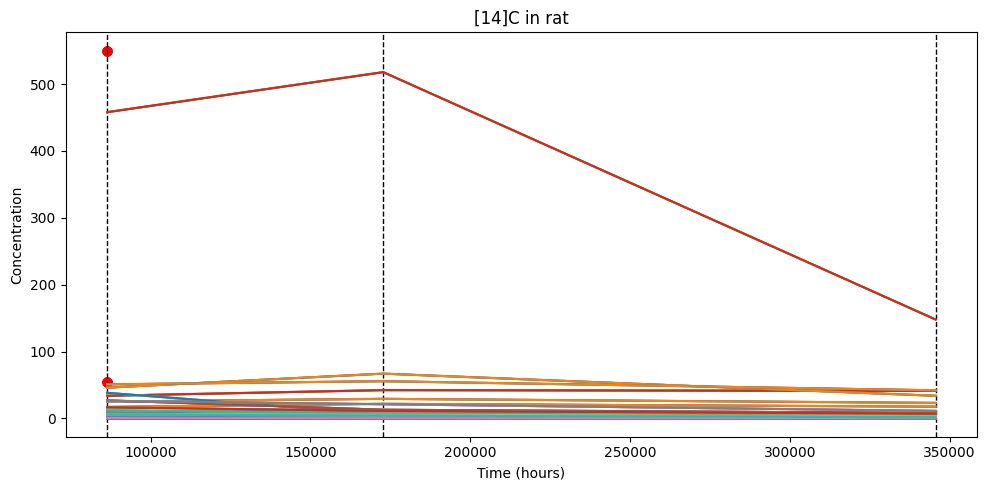

In [20]:
plot_series_by_species(group)

In [21]:
group.dose_level_normalized.value_counts()

dose_level_normalized
55.0     60
550.0    60
Name: count, dtype: int64

In [22]:
np.random.seed(0)
unique_series = group.fk_series_id.unique()
n_test_series = int(len(unique_series) * 0.2)
test_ids = np.random.choice(unique_series, n_test_series, replace = False)

In [23]:
group["ds_type"] = group.fk_series_id.apply(lambda x: "train" if x not in test_ids else "test")
group["ds_type"].value_counts(True)

ds_type
train    0.8
test     0.2
Name: proportion, dtype: float64

In [24]:
group.value_counts(["ds_type", "dose_level_normalized"], True)

ds_type  dose_level_normalized
train    550.0                    0.425
         55.0                     0.375
test     55.0                     0.125
         550.0                    0.075
Name: proportion, dtype: float64

In [25]:
group.to_csv("Dataset/training_data.csv")

We are now manually creating a test group and a training group for the sake of clarity.